__Tutorial 2: Effects of Input Correlation__
***

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import time

# Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

# Plotting Functions

def example_plot_myCC():
  pars = default_pars(T=50000, dt=.1)

  c = np.arange(10) * 0.1
  r12 = np.zeros(10)
  for i in range(10):
    I1gL, I2gL = correlate_input(pars, mu=20.0, sig=7.5, c=c[i])
    r12[i] = my_CC(I1gL, I2gL)

  plt.figure()
  plt.plot(c, r12, 'bo', alpha=0.7, label='Simulation', zorder=2)
  plt.plot([-0.05, 0.95], [-0.05, 0.95], 'k--', label='y=x',
           dashes=(2, 2), zorder=1)
  plt.xlabel('True CC')
  plt.ylabel('Sample CC')
  plt.legend(loc='best')



# the function plot the raster of the Poisson spike train
def my_raster_Poisson(range_t, spike_train, n):
  """
  Generates poisson trains

  Args:
    range_t     : time sequence
    spike_train : binary spike trains, with shape (N, Lt)
    n           : number of Poisson trains plot

  Returns:
    Raster plot of the spike train
  """

  # find the number of all the spike trains
  N = spike_train.shape[0]

  # n should smaller than N:
  if n > N:
    print('The number n exceeds the size of spike trains')
    print('The number n is set to be the size of spike trains')
    n = N

  # plot rater
  i = 0
  while i < n:
    if spike_train[i, :].sum() > 0.:
      t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
      plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
    i += 1
  plt.xlim([range_t[0], range_t[-1]])
  plt.ylim([-0.5, n + 0.5])
  plt.xlabel('Time (ms)', fontsize=12)
  plt.ylabel('Neuron ID', fontsize=12)

def plot_c_r_LIF(c, r, mycolor, mylabel):
  z = np.polyfit(c, r, deg=1)
  c_range = np.array([c.min() - 0.05, c.max() + 0.05])
  plt.plot(c, r, 'o', color=mycolor, alpha=0.7, label=mylabel, zorder=2)
  plt.plot(c_range, z[0] * c_range + z[1], color=mycolor, zorder=1)

# Helper Functions
def default_pars(**kwargs):
  pars = {}

  ### typical neuron parameters###
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -75.   # initial potential [mV]
  pars['V_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  ### simulation parameters ###
  pars['T'] = 400. # Total duration of simulation [ms]
  pars['dt'] = .1  # Simulation time step [ms]

  ### external parameters if any ###
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized
                                                         # time points [ms]
  return pars


def run_LIF(pars, Iinj):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value or an array

  Returns:
    rec_spikes : spike times
    rec_v      : mebrane potential
  """

  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, V_L = pars['V_init'], pars['V_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']

  # Initialize voltage and current
  v = np.zeros(Lt)
  v[0] = V_init
  Iinj = Iinj * np.ones(Lt)
  tr = 0.

  # simulate the LIF dynamics
  rec_spikes = []   # record spike times
  for it in range(Lt - 1):
    if tr > 0:
      v[it] = V_reset
      tr = tr - 1
    elif v[it] >= V_th:  # reset voltage and record spike event
      rec_spikes.append(it)
      v[it] = V_reset
      tr = tref / dt

    # calculate the increment of the membrane potential
    dv = (-(v[it] - V_L) + Iinj[it] / g_L) * (dt / tau_m)

    # update the membrane potential
    v[it + 1] = v[it] + dv

  rec_spikes = np.array(rec_spikes) * dt

  return v, rec_spikes


def my_GWN(pars, sig, myseed=False):
  """
  Function that calculates Gaussian white noise inputs

  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same random number sequence

  Returns:
    I          : Gaussian white noise input
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Set random seed. You can fix the seed of the random number generator so
  # that the results are reliable however, when you want to generate multiple
  # realization make sure that you change the seed for each new realization
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate GWN
  # we divide here by 1000 to convert units to sec.
  I_GWN = sig * np.random.randn(Lt) * np.sqrt(pars['tau_m'] / dt)

  return I_GWN


def LIF_output_cc(pars, mu, sig, c, bin_size, n_trials=20):
  """ Simulates two LIF neurons with correlated input and computes output correlation

  Args:
  pars       : parameter dictionary
  mu         : noise baseline (mean)
  sig        : noise amplitute (standard deviation)
  c          : correlation coefficient ~[0, 1]
  bin_size   : bin size used for time series
  n_trials   : total simulation trials

  Returns:
  r          : output corr. coe.
  sp_rate    : spike rate
  sp1        : spike times of neuron 1 in the last trial
  sp2        : spike times of neuron 2 in the last trial
  """

  r12 = np.zeros(n_trials)
  sp_rate = np.zeros(n_trials)
  for i_trial in range(n_trials):
    I1gL, I2gL = correlate_input(pars, mu, sig, c)
    _, sp1 = run_LIF(pars, pars['g_L'] * I1gL)
    _, sp2 = run_LIF(pars, pars['g_L'] * I2gL)

    my_bin = np.arange(0, pars['T'], bin_size)

    sp1_count, _ = np.histogram(sp1, bins=my_bin)
    sp2_count, _ = np.histogram(sp2, bins=my_bin)

    r12[i_trial] = my_CC(sp1_count[::20], sp2_count[::20])
    sp_rate[i_trial] = len(sp1) / pars['T'] * 1000.

  return r12.mean(), sp_rate.mean(), sp1, sp2

To generate correlated GWN input currents, we implement the following function:
$$
\frac{I_i}{g_L} = \mu_i + \sigma_i ( \eta_i \sqrt{1 - c} + \eta_c \sqrt{c})
$$
where $I_i$ is the input current into the $i$-th neuron, /eta_i is the noise component inedependent for the $i$-th neuron, and $\eta_c$ is the noise component common to all neurons. Below we generate correlated GWN input currents for two LIF neurons.

In [3]:
# Execute this cell to get a function `correlate_input` for generating correlated GWN inputs
def correlate_input(pars, mu=20., sig=7.5, c=0.3):
  """
  Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    c.         : correlation coefficient ~[0, 1]

  Returns:
    I1gL, I2gL : two correlated inputs with corr. coe. c
  """

  # generate Gaussian whute noise xi_1, xi_2, xi_c
  xi_1 = my_GWN(pars, sig)
  xi_2 = my_GWN(pars, sig)
  xi_c = my_GWN(pars, sig)

  # Generate two correlated inputs by Equation. (1)
  I1gL = mu + np.sqrt(1. - c) * xi_1 + np.sqrt(c) * xi_c
  I2gL = mu + np.sqrt(1. - c) * xi_2 + np.sqrt(c) * xi_c

  return I1gL, I2gL

We can also compute the _sample correlation coefficient_ (a.k.a. Pearson correlation) between two time series (input currents) with the following formula:
$$
...
$$

In [6]:
def my_CC(i, j):
  """
  Args:
    i, j  : two time series with the same length

  Returns:
    rij   : correlation coefficient
  """
  # Calculate the covariance of i and j
  cov = ((i - i.mean()) * (j - j.mean())).sum()

  # Calculate the variance of i
  var_i = ((i - i.mean()) ** 2).sum()

  # Calculate the variance of j
  var_j = ((j - j.mean()) ** 2).sum()

  # Calculate the correlation coefficient
  rij = cov / (np.sqrt(var_i) * np.sqrt(var_j))

  return rij

Next, we use the Poisson distribution to model spike trains in the function below. The distribution has the following characteristics:
- The ratio of the mean and variance of spike count is 1
- Inter-spike-intervals are exponentially distributed
- Spike times are irregular (i.e. $CV_{ISI}=1$)
- Adjacent spike intervals are independent of each other.

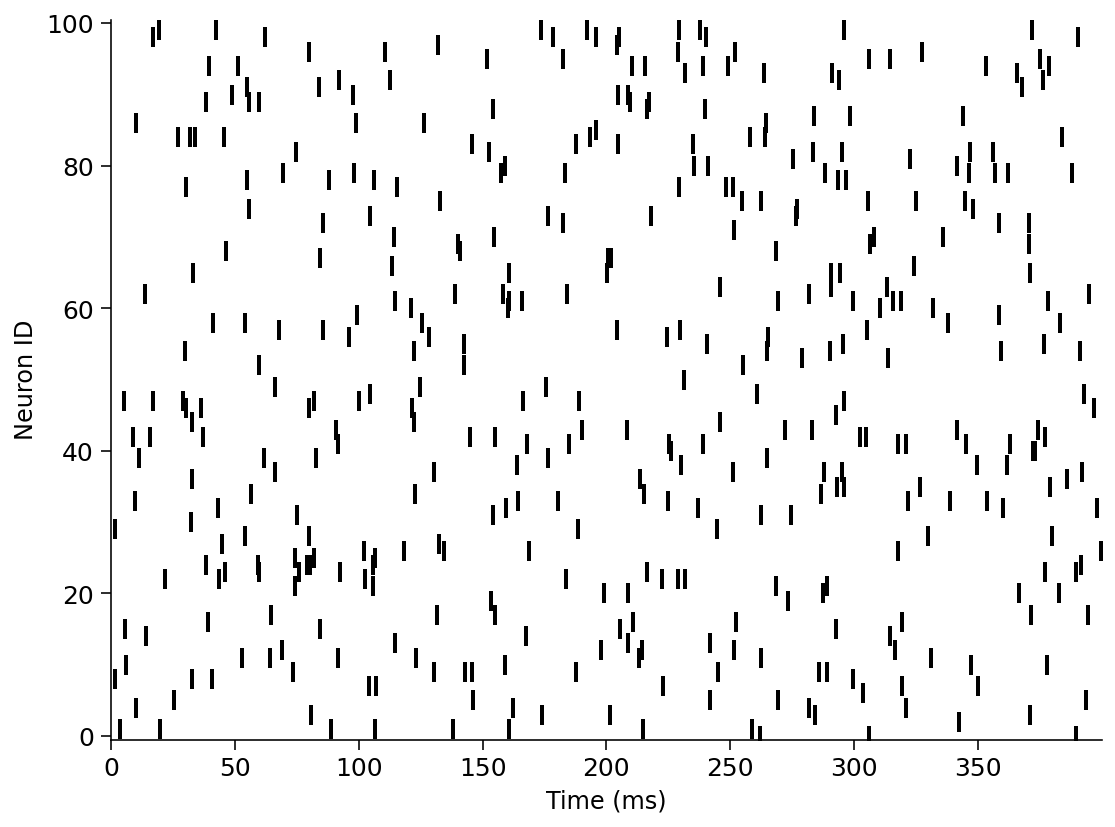

In [8]:
def Poisson_generator(pars, rate, n, myseed=False):
  """
  Generates poisson trains

  Args:
    pars       : parameter dictionary
    rate       : noise amplitute [Hz]
    n          : number of Poisson trains
    myseed     : random seed. int or boolean

  Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # generate uniformly distributed random variables
  u_rand = np.random.rand(n, Lt)

  # generate Poisson train
  poisson_train = 1. * (u_rand < rate * (dt / 1000.))

  return poisson_train

pars = default_pars()
pre_spike_train = Poisson_generator(pars, rate=10, n=100, myseed=2020)
my_raster_Poisson(pars['range_t'], pre_spike_train, 100)

We can use the function above to generate generate correlated spike time trains as implemented by _generate_corr_Poisson_ below. We then implement _corr_coeff_pairs_ to calculate the correlation coefficient between two spike trains.

In [9]:
def generate_corr_Poisson(pars, poi_rate, c, myseed=False):
  """
  function to generate correlated Poisson type spike trains
  Args:
    pars       : parameter dictionary
    poi_rate   : rate of the Poisson train
    c.         : correlation coefficient ~[0, 1]

  Returns:
    sp1, sp2   : two correlated spike time trains with corr. coe. c
  """

  range_t = pars['range_t']

  mother_rate = poi_rate / c
  mother_spike_train = Poisson_generator(pars, rate=mother_rate,
                                         n=1, myseed=myseed)[0]
  sp_mother = range_t[mother_spike_train > 0]

  L_sp_mother = len(sp_mother)
  sp_mother_id = np.arange(L_sp_mother)
  L_sp_corr = int(L_sp_mother * c)

  np.random.shuffle(sp_mother_id)
  sp1 = np.sort(sp_mother[sp_mother_id[:L_sp_corr]])

  np.random.shuffle(sp_mother_id)
  sp2 = np.sort(sp_mother[sp_mother_id[:L_sp_corr]])

  return sp1, sp2

def corr_coeff_pairs(pars, rate, c, trials, bins):
  """
  Calculate the correlation coefficient of two spike trains, for different
  realizations

  Args:
      pars   : parameter dictionary
      rate   : rate of poisson inputs
      c      : correlation coefficient ~ [0, 1]
      trials  : number of realizations
      bins   : vector with bins for time discretization

  Returns:
    r12      : correlation coefficient of a pair of inputs
  """

  r12 = np.zeros(n_trials)

  for i in range(n_trials):
    # Generate correlated Poisson inputs ('myseed' is defined for reproducibility)
    sp1, sp2 = generate_corr_Poisson(pars, rate, c, myseed=2020+i)

    # Bin the spike times of the first input
    sp1_count, _ = np.histogram(sp1, bins=bins)

    # Bin the spike times of the second input
    sp2_count, _ = np.histogram(sp2, bins=bins)

    # Calculate the correlation coefficient
    r12[i] = my_CC(sp1_count, sp2_count)

  return r12


poi_rate = 20.
c = 0.2  # set true correlation
pars = default_pars(T=10000)

# bin the spike time
bin_size = 20  # [ms]
my_bin = np.arange(0, pars['T'], bin_size)
n_trials = 100  # 100 realizations

r12 = corr_coeff_pairs(pars, rate=poi_rate, c=c, trials=n_trials, bins=my_bin)
print(f'True corr coe = {c:.3f}')
print(f'Simu corr coe = {r12.mean():.3f}')

True corr coe = 0.200
Simu corr coe = 0.197


We now explore the effect of the input correlation on the output correlation between two neurons. Using the function _LIF_output_cc_, we generate two correlated inputs from _correlate_inputs_,run the LIF model for the two neurons with these correlated inputs, and lastly compute the output correlation using _my_CC_ (the simulation is run for 10 trials to obtain a more accurate estimate of the output correlation).

Simulation time = 0.02 min
Input correlation = 0.5
Output correlation = 0.22679320370431494


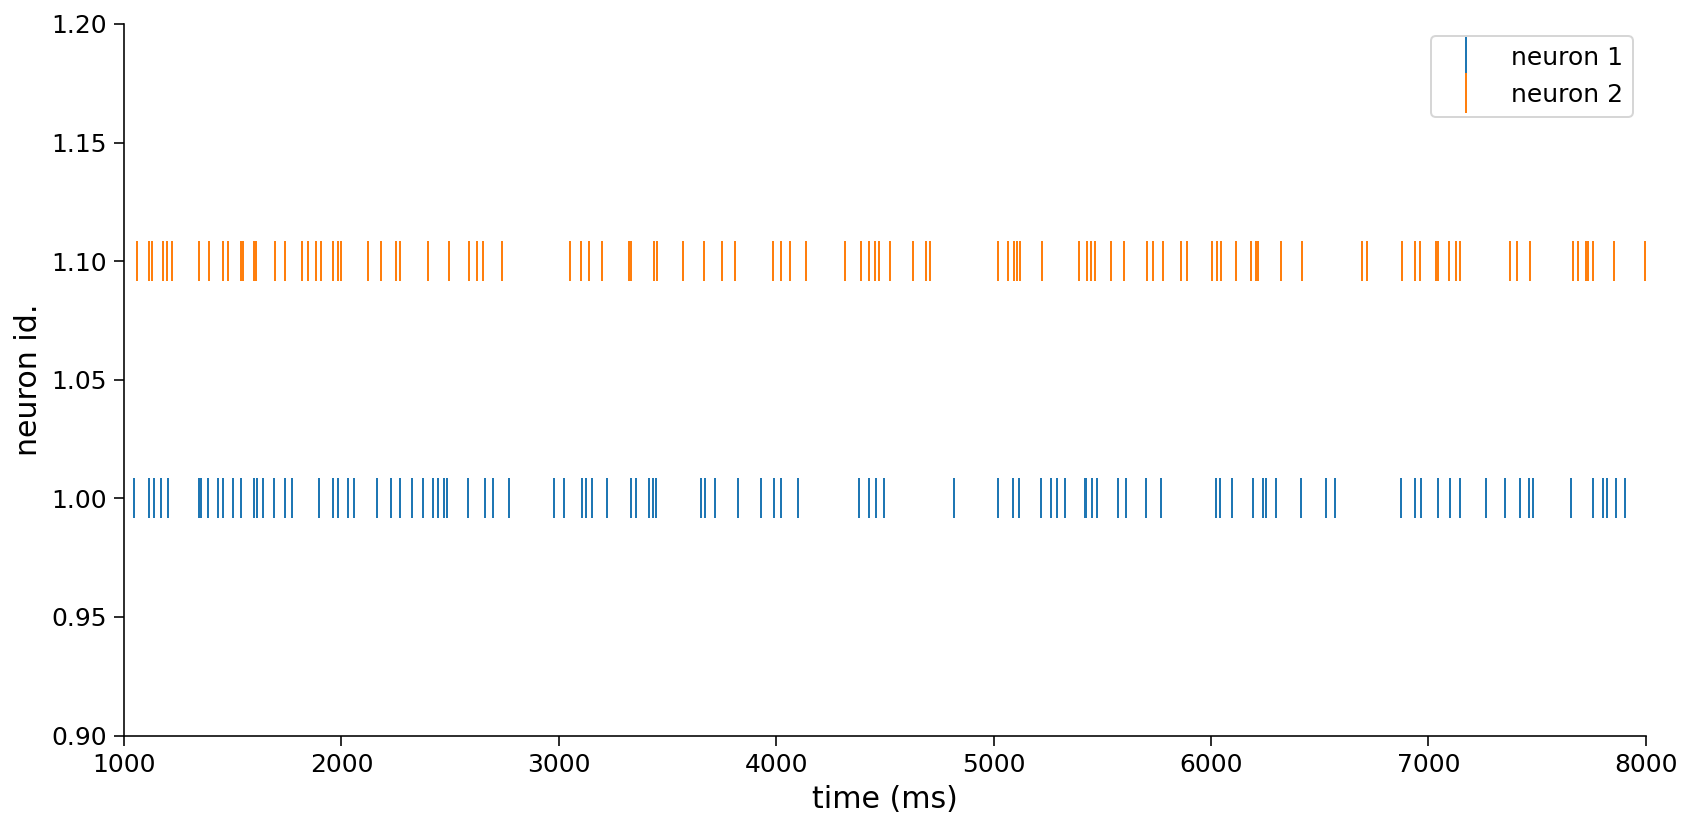

In [24]:
pars = default_pars(T=80000, dt=1.)  # get the parameters
c_in = 0.5  # set input correlation value
gwn_mean = 10.
gwn_std = 10.

bin_size = 10.  # ms

starttime = time.perf_counter()  # time clock

r12_ss, sp_ss, sp1, sp2 = LIF_output_cc(pars, mu=gwn_mean, sig=gwn_std, c=c_in,
                                        bin_size=bin_size, n_trials=10)

# just the time counter
endtime = time.perf_counter()
timecost = (endtime - starttime) / 60.
print(f"Simulation time = {timecost:.2f} min")

print(f"Input correlation = {c_in}")
print(f"Output correlation = {r12_ss}")

plt.figure(figsize=(12, 6))
plt.plot(sp1, np.ones(len(sp1)) * 1, '|', ms=20, label='neuron 1')
plt.plot(sp2, np.ones(len(sp2)) * 1.1, '|', ms=20, label='neuron 2')
plt.xlabel('time (ms)')
plt.ylabel('neuron id.')
plt.xlim(1000, 8000)
plt.ylim(0.9, 1.2)
plt.legend()
plt.show()

Below we explore the relationship between the input and output correlation by plotting the correlations transfer function. We see that the output correlation increases linearly with increasing input correlation, but it is always less than the input correlation.

Simulation time = 0.23 min


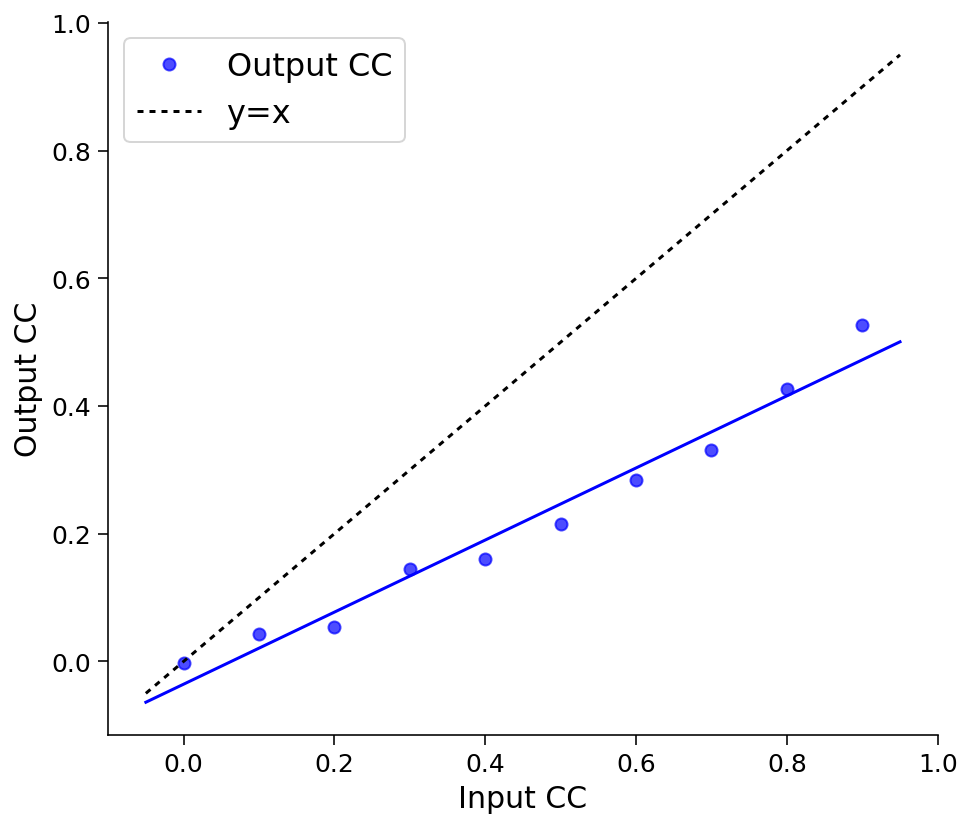

In [25]:
pars = default_pars(T=80000, dt=1.)  # get the parameters
bin_size = 10.
c_in = np.arange(0, 1.0, 0.1)  # set the range for input CC
r12_ss = np.zeros(len(c_in))  # small mu, small sigma

starttime = time.perf_counter() # time clock
for ic in range(len(c_in)):
  r12_ss[ic], sp_ss, sp1, sp2 = LIF_output_cc(pars, mu=10.0, sig=10.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=10)

endtime = time.perf_counter()
timecost = (endtime - starttime) / 60.
print(f"Simulation time = {timecost:.2f} min")

plt.figure(figsize=(7, 6))
plot_c_r_LIF(c_in, r12_ss, mycolor='b', mylabel='Output CC')
plt.plot([c_in.min() - 0.05, c_in.max() + 0.05],
         [c_in.min() - 0.05, c_in.max() + 0.05],
         'k--', dashes=(2, 2), label='y=x')

plt.xlabel('Input CC')
plt.ylabel('Output CC')
plt.legend(loc='best', fontsize=16)
plt.show()

Next we explore how various choices for the mean and variance for the GWN of the inputs changes the curve of the transfer function. (Answer: why do both the mean andstandard deviation of the GWN affect the slope?)

Simulation time = 0.33 min


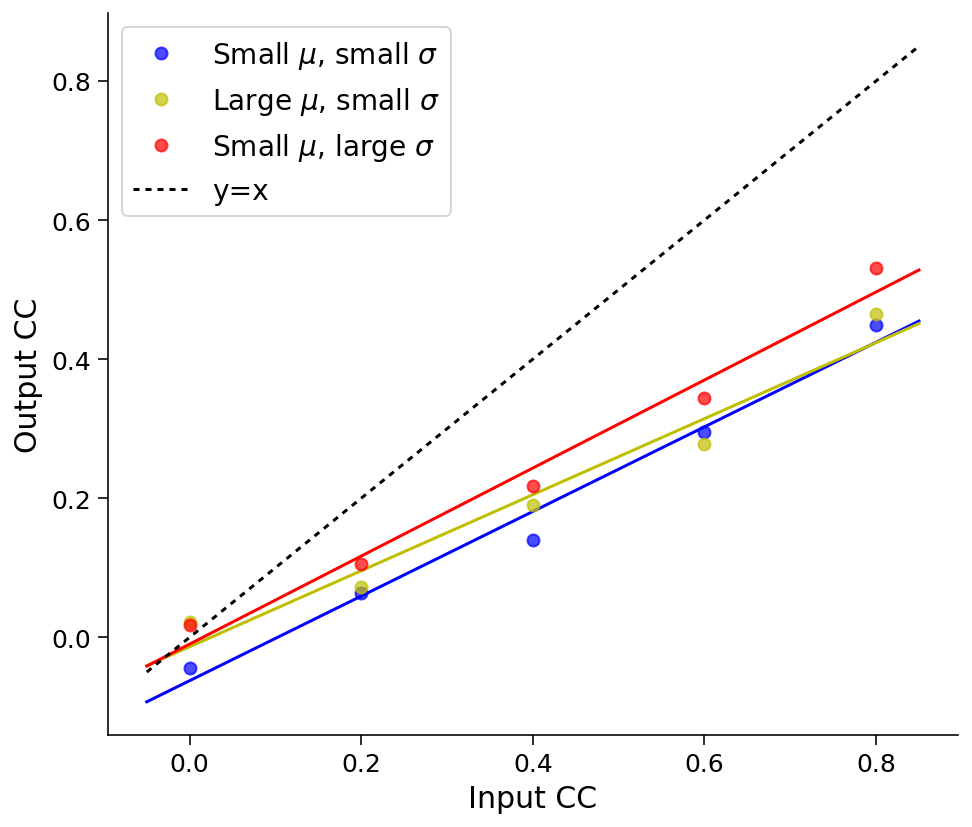

In [26]:
pars = default_pars(T=80000, dt=1.) # get the parameters
no_trial = 10
bin_size = 10.
c_in = np.arange(0., 1., 0.2)  # set the range for input CC
r12_ss = np.zeros(len(c_in))   # small mu, small sigma
r12_ls = np.zeros(len(c_in))   # large mu, small sigma
r12_sl = np.zeros(len(c_in))   # small mu, large sigma

starttime = time.perf_counter()  # time clock
for ic in range(len(c_in)):
  r12_ss[ic], sp_ss, sp1, sp2 = LIF_output_cc(pars, mu=10.0, sig=10.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=no_trial)
  r12_ls[ic], sp_ls, sp1, sp2 = LIF_output_cc(pars, mu=18.0, sig=10.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=no_trial)
  r12_sl[ic], sp_sl, sp1, sp2 = LIF_output_cc(pars, mu=10.0, sig=20.,
                                              c=c_in[ic], bin_size=bin_size,
                                              n_trials=no_trial)
endtime = time.perf_counter()
timecost = (endtime - starttime) / 60.
print(f"Simulation time = {timecost:.2f} min")

plt.figure(figsize=(7, 6))
plot_c_r_LIF(c_in, r12_ss, mycolor='b', mylabel=r'Small $\mu$, small $\sigma$')
plot_c_r_LIF(c_in, r12_ls, mycolor='y', mylabel=r'Large $\mu$, small $\sigma$')
plot_c_r_LIF(c_in, r12_sl, mycolor='r', mylabel=r'Small $\mu$, large $\sigma$')
plt.plot([c_in.min() - 0.05, c_in.max() + 0.05],
         [c_in.min() - 0.05, c_in.max() + 0.05],
         'k--', dashes=(2, 2), label='y=x')
plt.xlabel('Input CC')
plt.ylabel('Output CC')
plt.legend(loc='best', fontsize=14)
plt.show()